In [1]:
#Code Adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html 
# This code creates the model we use for vehicle detection and shows predictions and evaluation of the model

In [ ]:
%%shell
pip install cython 
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [2]:
# Library imports
from PIL import Image
import time, math, cv2, imutils, os, json, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
TRAIN_DIR = Path.cwd().parent.joinpath('content/drive/MyDrive/benchmark_velocity_train/clips')
TEST_DIR = Path.cwd().parent.joinpath('content/drive/MyDrive/benchmark_velocity_test/clips')

# Data Pre-processing

In [4]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all labels
        self.clip_nums = [x for x in os.listdir(self.root) if 'DS_Store' not in x]
        self.img_paths = [Path(root).joinpath(num).joinpath('imgs').joinpath('040.jpg') for num in self.clip_nums]
        self.anno = [Path(root).joinpath(x).joinpath('annotation.json') for x in self.clip_nums]

    def __getitem__(self, idx):
        # load images and masks
        anno_pth = self.anno[idx]
        with open(anno_pth) as f:
            anno_data = json.load(f)
        
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        mask = np.zeros(np.array(img).shape[0:2])
        boxes = []

        for car in anno_data:
            print()
            left = int(car['bbox']['left'])
            right = int(car['bbox']['right'])
            top = int(car['bbox']['top'])
            bottom = int(car['bbox']['bottom'])
            start_point = (left, top)
            end_point = (right, bottom)  
            color =  1
            thickness = -1
            # Add bounding box
            mask = cv2.rectangle(mask, start_point, end_point, color, thickness) 

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

# Load Pre-trained Model

In [5]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../ &> /dev/null
cp references/detection/transforms.py ../ &> /dev/null
cp references/detection/coco_eval.py ../ &> /dev/null
cp references/detection/engine.py ../ &> /dev/null
cp references/detection/coco_utils.py ../ &> /dev/null

# Model Training

In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
# use our dataset and defined transformations
dataset_train = CarDataset(TRAIN_DIR, get_transform(train=True))
dataset_valid = CarDataset(TRAIN_DIR, get_transform(train=False))

# split the dataset in train and validation sets
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()
TRAIN_SIZE = int(0.8*len(indices))
dataset_train = torch.utils.data.Subset(dataset_train, indices[:TRAIN_SIZE])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[TRAIN_SIZE:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
   dataset_valid, batch_size=1, shuffle=False, num_workers=4,
   collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and car
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [13]:
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

# Inference

In [102]:
%%capture
model = torch.load('drive/MyDrive/carDetectionModel.pkl')
default_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
default_model.to(device)

In [25]:
dataset_test = CarDataset(TEST_DIR, get_transform(train=False))

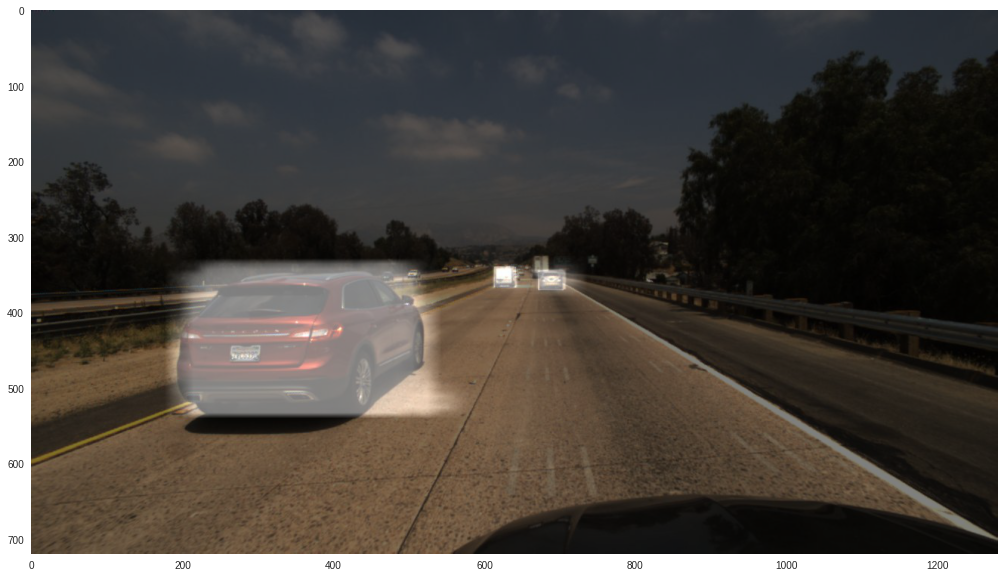

<Figure size 576x396 with 0 Axes>

In [110]:
idx = 50
# pick one image from the test set
img, _ = dataset_test[idx]
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)])

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

plt.figure(figsize=(20,10))
plt.grid(b=None)
plt.imshow(image)
mask = np.zeros(img.shape[1:])

for n in range(len(prediction[0]['masks'])):
    mask += prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy()


mask = Image.fromarray(mask)
plt.imshow(mask, cmap='jet', alpha=0.50)
plt.show()

plt.savefig(f'preds/pred_{idx}.jpg')

In [113]:
%%capture 
for idx in range(50):
    # pick one image from the test set
    img, _ = dataset_test[idx]
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        prediction = model([img.to(device)])

    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

    plt.figure(figsize=(20,10))
    plt.grid(b=None)
    plt.imshow(image)
    mask = np.zeros(img.shape[1:])

    for n in range(len(prediction[0]['masks'])):
    mask += prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy()


    mask = Image.fromarray(mask)
    plt.imshow(mask, cmap='jet', alpha=0.50)
    #plt.show()

    plt.savefig(f'preds/pred_{idx}.jpg')

In [115]:
import cv2
import os

image_folder = 'preds'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 2, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
count_parameters(model)

43699995

In [29]:
#torch.save(model, 'drive/MyDrive/carDetectionModel.pkl')

In [30]:
def get_bboxes(mask, offset=None):
    # get bboxes from mask (bboxes returned from the model are not suitable,
    # but can be retrieved from the mask)
    # applies connected components algorithm to get bboxes
    equivalencies = {}
    box_areas=defaultdict(list)
    labels = np.zeros(mask.shape).astype(int)
    rows = mask.shape[0]
    cols = mask.shape[1]
    label = 1

    for i in range(rows):
        for j in range(cols):
            current = mask[i][j]
            north = None
            north_label = None
            west = None
            west_label = None

            if i > 0:
                try:
                    north = mask[i-1][j]
                    if north:
                        north_label = labels[i-1][j]
                    else:
                        north = None
                        north_label = None
                except:
                    pass
            if j > 0:
                try:
                    west = mask[i][j-1]
                    if west:
                        west_label = labels[i][j-1]
                    else:
                        west = None
                        west_label = None
                except:
                    pass

            if north and west:
                if north_label == west_label:
                    labels[i][j] = north_label
                else:
                    min_label = int(min(north_label, west_label))
                    max_label = int(max(north_label, west_label))
                    if min_label not in equivalencies[max_label]:
                        equivalencies[max_label].append(min_label)
                    labels[i][j] = min_label

            elif north:
                labels[i][j] = north_label

            elif west:
                labels[i][j] = west_label

            else:
                if current:
                    labels[i][j] = label
                    equivalencies[label]=[label]
                    label += 1

    for i in equivalencies.keys():
        equivalencies[i] = int(min(equivalencies[i]))
        equivalencies[i] = equivalencies[equivalencies[i]]

    for i in range(rows):
        for j in range(cols):
            if labels[i][j]:
                labels[i][j] = equivalencies[labels[i][j]]
                box_areas[labels[i][j]].append((i,j))

    bboxes=[]
    for i in box_areas:
        box = np.array(box_areas[i])
        box.reshape(-1, 2)
        box = np.hsplit(box, 2)
        rows = box[0]
        cols = box[1]
        left = np.amin(cols)
        top = np.amin(rows)
        right = np.amax(cols)
        bottom = np.amax(rows)
        if offset:
            bboxes.append({'top': top+offset['top'], 'left': left+offset['left'], 'bottom': bottom+offset['top'], 'right': right+offset['left']})
        else:
            bboxes.append({'top': top, 'left': left, 'bottom': bottom, 'right': right})
    return bboxes

In [31]:
from torchvision.transforms import functional as F
from collections import defaultdict

def detect(img, model, visualize=False):
    # takes image as input, and returns estimated bboxes
    img = F.to_tensor(img)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    mask = np.zeros(img.shape[1:])
    for n in range(len(prediction[0]['masks'])):
        mask += prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy()
    mask = np.array(mask)
    mask *= (255.0/mask.max())
    # normalizing to CV_8UC1 for thresholding
    mask = cv2.normalize(src=mask, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    # applying otsu
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # other techniques I tried, Mean Adaptive Threshold gave some good results too
    #mask = contrast_stretch(mask)
    #t, mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
    #mask - cv2.medianBlur(mask, 7)
    #mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 73, 0)
    #mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 999, 2)

    # extracting only the area that contains all masks (for efficiency)
    m = cv2.findNonZero(mask)
    m = m.reshape(-1, 2)
    m = np.hsplit(m, 2)
    cols = m[0]
    rows = m[1]
    left, top, right, bottom = np.amin(cols), np.amin(rows), np.amax(cols), np.amax(rows)
    # offset (top left corner of the mask)
    offset = {'top':top, 'left':left}
    roi = mask[top:bottom, left:right]
    # apply connected components, add the offset later to the found boxes
    # to scale back to the original image's size
    bboxes = get_bboxes(roi, offset)
    # draw bboxes
    if visualize:
        cv_image = np.array(image)
        for box in bboxes:
            top, left, bottom, right = int(box['top']), int(box['left']), int(box['bottom']), int(box['right'])
            cv_image = cv2.rectangle(cv_image, (left, top), (right, bottom), (0,200,0), 6)
        show_image(cv_image)
    return bboxes

In [32]:
def show_image(image, gray=False, size=(10, 20), title=None, save_title=None):
    plt.style.use('seaborn')
    plt.figure(figsize=(size[0], size[1]))
    plt.title(title, fontweight='bold', size=20)
    if gray:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(image, vmin=0, vmax=255)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if save_title:
        plt.savefig(save_title+'.jpg')
    plt.show()

In [33]:
def show_preds(model,idx):
    # pick one image from the test set
    img, _ = dataset_test[idx]
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    detect(img,model, visualize=True)

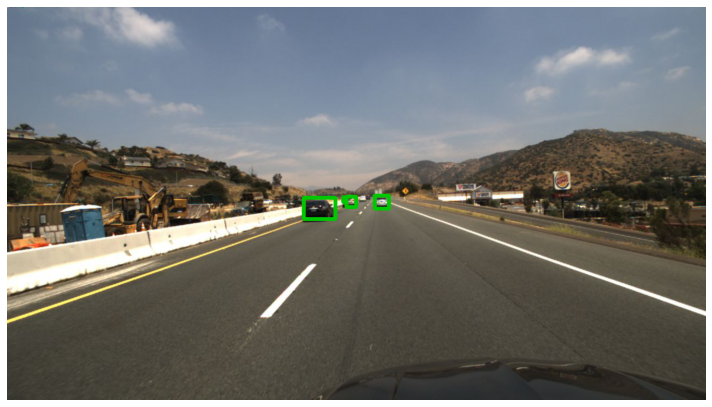

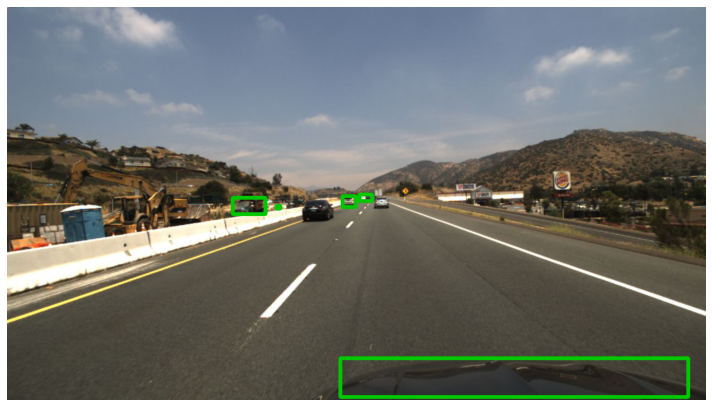

In [34]:
idx = 54
# Display results with and without transfer learning
show_preds(model,idx)
show_preds(default_model,idx)

# Model Evaluation

In [35]:
def calc_iou(mask,gt):
    intersection = sum(sum((mask) & (gt)))
    union = sum(sum((mask) | (gt)))
    iou = intersection/union

    return iou

In [75]:
def calc_test_iou(model,dataset_test,threshs,default):
  
  ious = {}

    for thresh in threshs:
        ious[thresh] = []

    for img, target in dataset_test:
        # Load each image in test set
        with torch.no_grad():
            prediction = model([img.to(device)])

        if default==False:
        # Testing Model with Transfer Learning
            mask = prediction[0]['masks'][0, 0].cpu().numpy()
        else:
            # Testing Model without Transfer Learning
            mask = np.zeros(img.shape[1:])
            car_count = 0
            for n in range(len(prediction[0]['masks'])):
                # Label 3 is Car in COCO dataset
                if prediction[0]['labels'][n]==3 and car_count < 1:
                    # Try to reduce false positives counts
                    car_count += 1
                    mask = np.maximum(mask, prediction[0]['masks'][n, 0].mul(256).byte().cpu().numpy()/256)

        # Get ground Truth Masks
        gt = target['masks'][0].mul(255).byte().cpu().numpy()
        gt = gt > 0
        for thresh in threshs:
            #Calculate IOUs for a range of thresholds
            thresh_ious = ious[thresh]
            mask_t = mask > thresh
            iou = calc_iou(mask_t,gt)
            thresh_ious.append(iou)

    return ious

In [ ]:
%%capture
default_ious = calc_test_iou(default_model,dataset_test,threshs = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95],default=True)

In [100]:
print('Without Transfer Learning: \n')
for key in default_ious:
    print(key,np.mean(default_ious[key]))
    print('-----')

Without Transfer Learning: 

0.5 0.19233330232815662
-----
0.55 0.1887954869723017
-----
0.6 0.18479394191127899
-----
0.65 0.1804524319964077
-----
0.7 0.17593278647951258
-----
0.75 0.17074120906974288
-----
0.8 0.16544551814244152
-----
0.85 0.15879754043327474
-----
0.9 0.15009610866948234
-----
0.95 0.1367618427870763
-----


In [77]:
%%capture
ious = calc_test_iou(model,dataset_test,threshs = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95],default=False)

In [101]:
print('With Transfer Learning: \n')
for key in ious:
    print(key,np.mean(ious[key]))
    print('-----')

With Transfer Learning: 

0.5 0.6286432274243563
-----
0.55 0.6292444689611866
-----
0.6 0.6291814263124197
-----
0.65 0.6282887843288906
-----
0.7 0.6268760578547097
-----
0.75 0.6240632242574669
-----
0.8 0.619590795661399
-----
0.85 0.6119396422641142
-----
0.9 0.5981153655745092
-----
0.95 0.569300307663485
-----


In [68]:
import pickle
with open("drive/MyDrive/ious_cd.pkl","wb") as pickle_out:
    pickle.dump(ious, pickle_out)import pickle

with open("drive/MyDrive/ious_cd_def.pkl","wb") as pickle_out:
    pickle.dump(default_ious, pickle_out)

In [87]:
def meanIOU(ious):
    all_ious = []
    for iou in ious.values():
        all_ious.extend(iou)

    return np.mean(all_ious)

In [97]:
print(f"Mean IOU for model with Transfer Learning: {meanIOU(ious):.2%}")
print(f"Mean IOU for model without Transfer Learning: {meanIOU(default_ious):.2%}")
print(f"Improvement Factor {meanIOU(ious)/meanIOU(default_ious):.2f}x")

Mean IOU for model with Transfer Learning: 61.65%
Mean IOU for model without Transfer Learning: 17.04%
Improvement Factor 3.62x
